In [1]:
library(Seurat)
library(dplyr)
library(speckle)

library(glue)

library(ggplot2)
library(ggh4x)
library(RColorBrewer)
library(ggpubr)
library(gridExtra)
library(ggsignif)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Data load

In [2]:
load('../data/commons.rda', verbose = T)

Loading objects:
  cell.type.colors
  cell.types
  cell.types.nohighmito
  chr_df
  donor_sex
  fig
  imprinted.df
  imprinted.genes
  monkey.genes
  monkey.markers
  nescreg.ct.list
  nescreg.genes
  nescreg.list
  nescreg.markers
  origin_sex.colors
  pat.de
  pat.list
  pat.neu.de
  pat.neu.list
  phases
  phases.colors
  region.genes
  region.list
  region.markers
  samples
  samples.colors
  sex_chr.genes
  sex_chr.genes.x
  sex_chr.genes.y
  tf.genes
  tfs.df
  top100.sub.pat
  top100.subtype
  valid_chr


In [3]:
results_dir <- '../results/proportion_tests/'
dir.create(results_dir)

Warning message in dir.create(results_dir):
“'../results/proportion_tests' already exists”


## Expression data: no high-mito

In [4]:
# Read
seu <- readRDS('../data/DE_DS.NoHighMito.pp.scaled.RDS')

# Parameters

In [5]:
# Important variables
cluster.var <- 'anno_cluster_fct'
phase.var <- 'Phase'
sample.var <- 'cell_origin'
group.var <- 'condition'

In [6]:
# Factors
seu$cell_origin <- factor(as.character(seu$cell_origin), samples)
seu$Phase <- factor(as.character(seu$Phase), phases)

In [7]:
# propeller config 
propeller.transform <- 'logit' # "asin" # 'logit'

# For names of arguments in propeller
seu$group <- seu@meta.data[,group.var]
seu$sample <- seu@meta.data[,sample.var]

# Propeller

## Phase

### Test

In [8]:
Idents(seu) <- phase.var

phase.results <- propeller(seu, transform = propeller.transform) %>% arrange(BaselineProp.clusters)

props <- getTransformedProps(seu$Phase, seu$sample, transform=propeller.transform)
plot.props <- props$Proportions %>% reshape2::melt()
plot.props <- plot.props %>% mutate(condition = sapply(as.character(sample), function(x) strsplit(x, split='_')[[1]][2]))

extracting sample information from Seurat object

Performing logit transformation of proportions

group variable has 2 levels, t-tests will be performed

Performing logit transformation of proportions



In [9]:
phase.results

,BaselineProp.clusters,BaselineProp.Freq,PropMean.ASD,PropMean.Ctrl,PropRatio,Tstatistic,P.Value,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G1,G1,0.4217237,0.4599747,0.3597299,1.2786667,4.1621348,0.004264638,0.006995903
S,S,0.2551962,0.2218448,0.3115283,0.7121176,-4.0905673,0.004663935,0.006995903
G2M,G2M,0.3230800,0.3181805,0.3287418,0.9678737,-0.7790366,0.461568220,0.461568220


### Plotting

#### Significance annotation

In [10]:
phase.results %>% mutate(
    clusters=BaselineProp.clusters, 
    sample='None',
    start='ASD', end='Ctrl',
    y=sapply(clusters,
             function(x){max(subset(plot.props, clusters==x)$value, na.rm=T)*1.1}),
    label = ifelse(FDR < 0.01, '**', ifelse(FDR < 0.05, '*', 'NS'))
) -> annotation_df

annotation_df <- subset(annotation_df, label!='NS')

#### Barplot

In [11]:
plot.props <- merge(annotation_df[,c('BaselineProp.clusters', 'label')], plot.props,
      by.x ='BaselineProp.clusters', by.y='clusters', all.x=F, all.y=T) %>% mutate(signif=grepl(pattern='*', x=label, fixed=T)) %>% rename(clusters=BaselineProp.clusters)

In [12]:
phase.props.per.donor <- ggplot(plot.props, aes(x=sample, y=value, fill=clusters, color=signif, alpha=signif)) + 
    geom_bar(stat='identity', position='fill') + 
    facet_grid2(cols=vars(condition), scales='free', space='fixed') + 
    scale_fill_manual('Cell-cycle phase', values = phases.colors) +
    scale_y_continuous(labels = scales::percent, expand = expansion(mult = c(0, 0))) + 
    theme_pubr(legend = 'top') + labs_pubr() +
    scale_alpha_manual(values=c('TRUE'=1, 'FALSE'=0.5)) + 
    scale_color_manual(values=c('TRUE'='black', 'FALSE'='transparent')) + 
    labs(x='Donor', y='Proportion', alpha='Significant difference', color='Significant difference') +
    theme(axis.text.x = element_text(angle = 45, vjust=1, hjust=1),
          axis.title.x = element_text(hjust=0),
          axis.title.y = element_text(hjust=0)) 

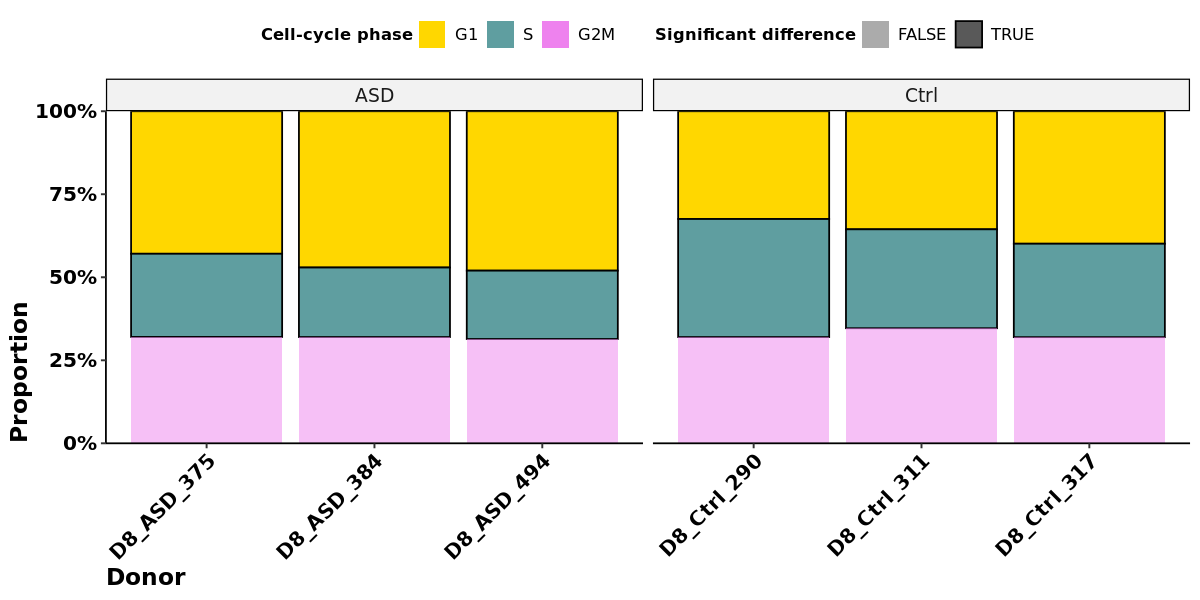

In [13]:
fig(10,5)
phase.props.per.donor

#### Scatter

In [14]:
phase.props.per.cluster <- ggplot(plot.props, aes(x=condition, y=value, fill=sample)) + 
    facet_grid2(cols=vars(clusters), scales='free', space='fixed', independent='y') + 
    geom_vline(xintercept = c('ASD', 'Ctrl'), color='lightgrey') +
    geom_jitter(shape=21, size=3, height = 0, width=0.1) + 
    scale_fill_manual('Donor', values = samples.colors) +
    scale_y_continuous(labels = scales::percent, expand = expansion(mult = c(0.1, 0.1))) + 
    theme_pubr(legend = 'top') + labs_pubr() +
    labs(x='Condition', y='Proportion') +
    theme(axis.title.x = element_text(hjust=0),
          axis.title.y = element_text(hjust=0)) + 

    geom_signif(
        data = annotation_df,
        aes(annotations = label, xmin = 'ASD', xmax = 'Ctrl', y_position = y),
        fill='black',
        vjust=,
        manual = TRUE)

Warning message in geom_signif(data = annotation_df, aes(annotations = label, xmin = "ASD", :
“Ignoring unknown parameters: `fill`”
Warning message in geom_signif(data = annotation_df, aes(annotations = label, xmin = "ASD", :
“Ignoring unknown aesthetics: annotations, xmin, xmax, and y_position”


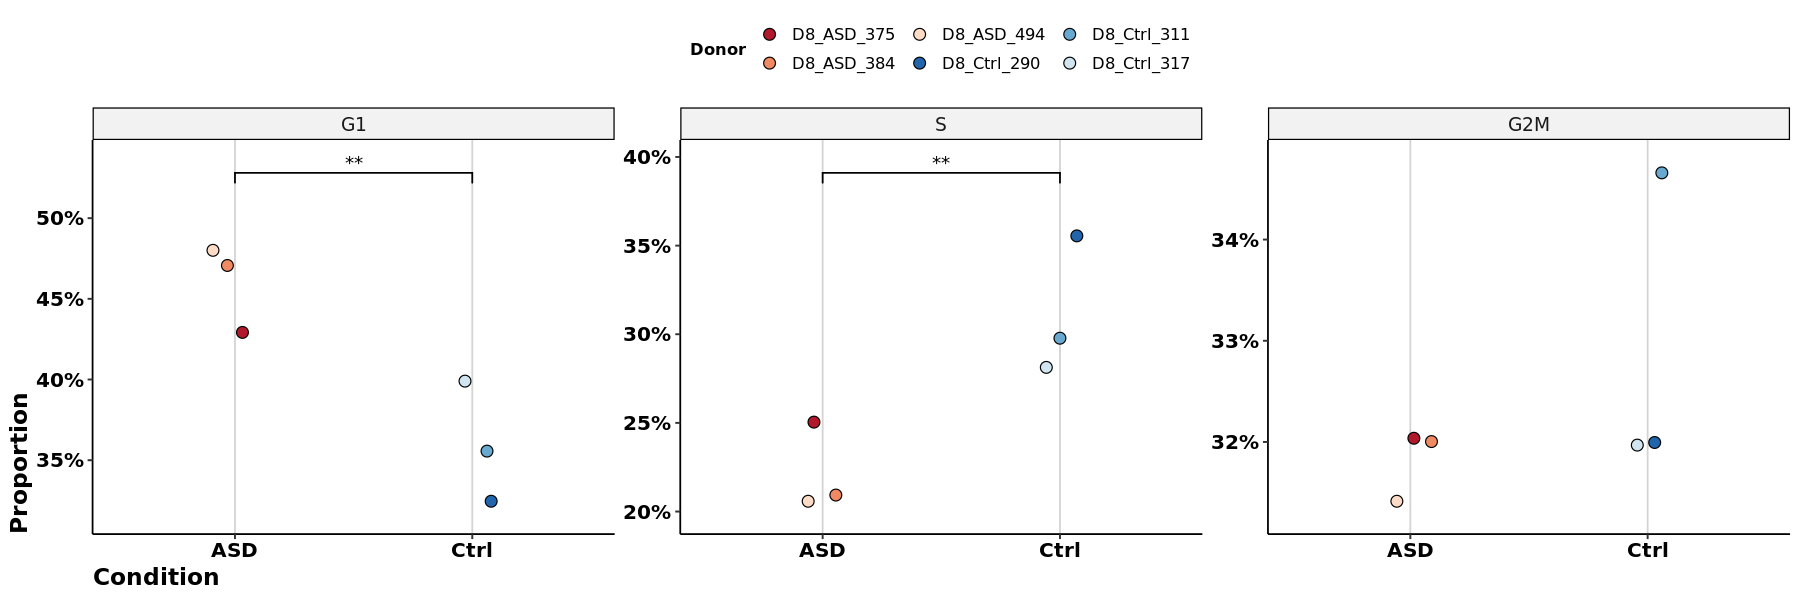

In [15]:
fig(15,5)
phase.props.per.cluster

### Export

In [16]:
# Export
my_table <- tableGrob(phase.results)

pdf(glue('{results_dir}Abundance.Test.Phases.{propeller.transform}.pdf'), width=12, height=5)
plot(phase.props.per.donor)
plot(phase.props.per.cluster)
plot(my_table)
dev.off()

png 
  2

## Cell types

### Test

In [17]:
Idents(seu) <- cluster.var

ct.results <- propeller(seu, transform = propeller.transform)%>%mutate(
    BaselineProp.clusters = factor(as.character(BaselineProp.clusters), levels=cell.types.nohighmito)
) %>% arrange(BaselineProp.clusters) 

props <- getTransformedProps(seu$anno_cluster_fct, seu$sample, transform=propeller.transform)
plot.props <- props$Proportions %>% reshape2::melt()%>%mutate(
    clusters = factor(as.character(clusters), levels=cell.types.nohighmito)
)
plot.props <- plot.props %>% mutate(condition = sapply(as.character(sample), function(x) strsplit(x, split='_')[[1]][2]))

extracting sample information from Seurat object

Performing logit transformation of proportions

group variable has 2 levels, t-tests will be performed

Performing logit transformation of proportions



### Plotting

#### Significance annotation

In [18]:
ct.results %>% mutate(
    clusters=BaselineProp.clusters, 
    sample='None',
    start='ASD', end='Ctrl',
    y=sapply(clusters,
             function(x){max(subset(plot.props, clusters==x)$value, na.rm=T)*1.1}),
    label = ifelse(FDR < 0.01, '**', ifelse(FDR < 0.05, '*', 'NS'))
) -> annotation_df

annotation_df <- subset(annotation_df, label!='NS')

#### Barplot

In [19]:
plot.props <- merge(annotation_df[,c('BaselineProp.clusters', 'label')], plot.props,
      by.x ='BaselineProp.clusters', by.y='clusters', all.x=F, all.y=T) %>% mutate(signif=grepl(pattern='*', x=label, fixed=T)) %>% rename(clusters=BaselineProp.clusters)

In [20]:
ct.props.per.donor <- ggplot(plot.props, aes(x=sample, y=value, fill=clusters, color=signif, alpha=signif)) + 
    geom_bar(stat='identity', position='fill') + 
    facet_grid2(cols=vars(condition), scales='free', space='fixed') + 
    scale_fill_manual('Cell type', values = cell.type.colors) +
    scale_y_continuous(labels = scales::percent, expand = expansion(mult = c(0, 0))) + 
    theme_pubr(legend = 'top') + labs_pubr() +
    scale_alpha_manual(values=c('TRUE'=1, 'FALSE'=0.5)) + 
    scale_color_manual(values=c('TRUE'='black', 'FALSE'='transparent')) + 
    labs(x='Donor', y='Proportion', alpha='Significant difference', color='Significant difference') +
    theme(axis.text.x = element_text(angle = 45, vjust=1, hjust=1),
          axis.title.x = element_text(hjust=0),
          axis.title.y = element_text(hjust=0))

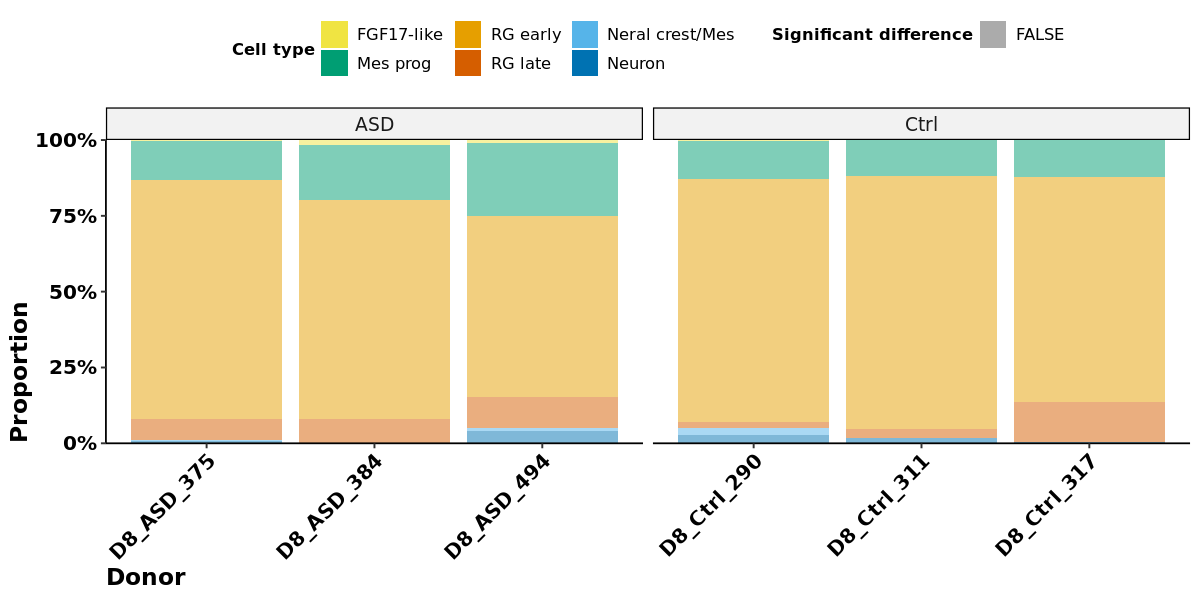

In [21]:
fig(10,5)
ct.props.per.donor

#### Scatter

In [22]:
ct.props.per.cluster <- ggplot(plot.props, aes(x=condition, y=value, fill=sample)) + 
    facet_grid2(cols=vars(clusters), scales='free', space='fixed', independent='y') + 
    geom_vline(xintercept = c('ASD', 'Ctrl'), color='lightgrey') +
    geom_jitter(shape=21, size=3, height = 0, width=0.1) + 
    scale_fill_manual('Donor', values = samples.colors) +
    scale_y_continuous(labels = scales::percent, expand = expansion(mult = c(0.1, 0.1))) + 
    theme_pubr(legend = 'top') + labs_pubr() +
    labs(x='Condition', y='Proportion') +
    theme(axis.title.x = element_text(hjust=0),
          axis.title.y = element_text(hjust=0)) + 

    geom_signif(
        data = annotation_df,
        aes(annotations = label, xmin = 'ASD', xmax = 'Ctrl', y_position = y),
        fill='black',
        vjust=,
        manual = TRUE)

Warning message in geom_signif(data = annotation_df, aes(annotations = label, xmin = "ASD", :
“Ignoring unknown parameters: `fill`”
Warning message in geom_signif(data = annotation_df, aes(annotations = label, xmin = "ASD", :
“Ignoring unknown aesthetics: annotations, xmin, xmax, and y_position”


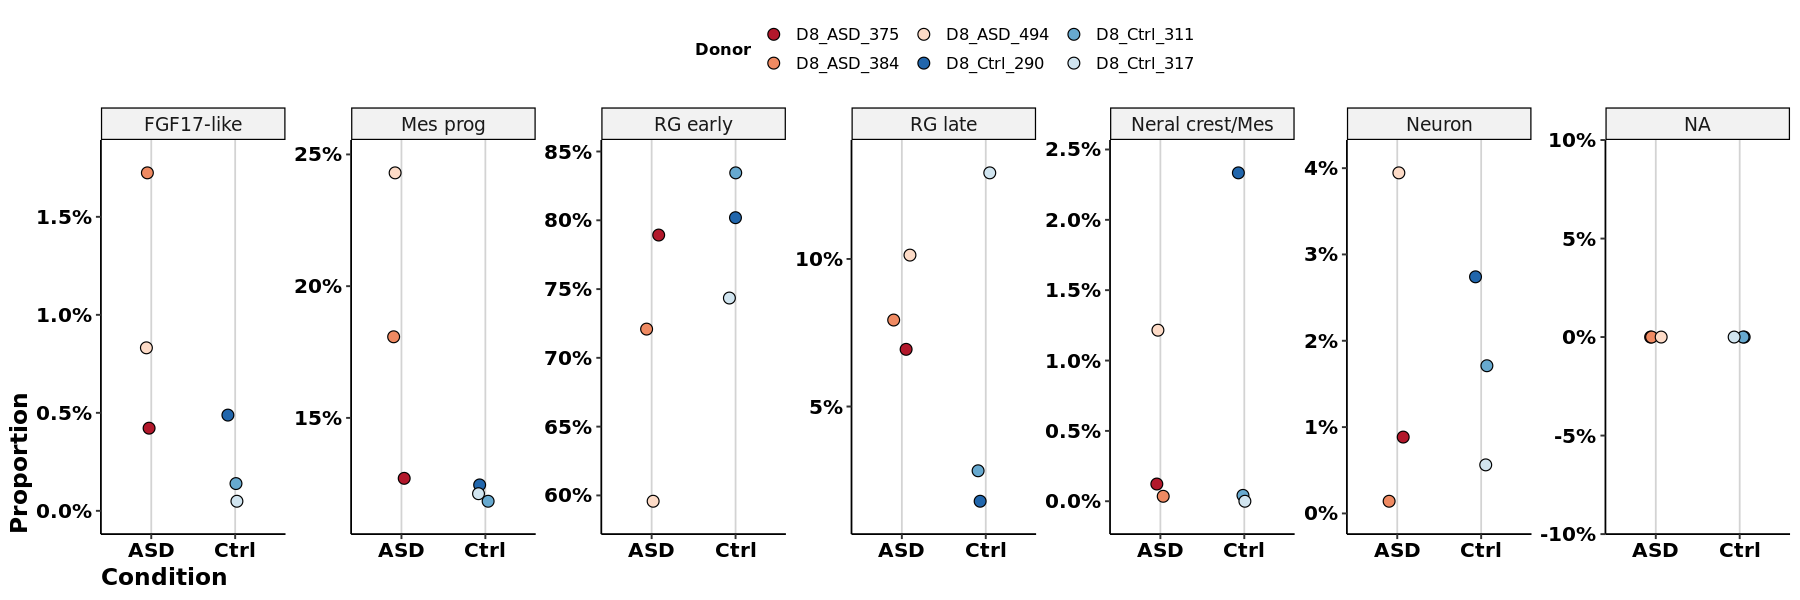

In [23]:
fig(15,5)
ct.props.per.cluster

### Export

In [24]:
# Export
my_table <- tableGrob(ct.results)

pdf(glue('{results_dir}Abundance.Test.CellTypes.{propeller.transform}.pdf'), width=15, height=5)
plot(ct.props.per.donor)
plot(ct.props.per.cluster)
plot(my_table)
dev.off()

png 
  2

## Phase per cell type

### Test

In [25]:
Idents(seu) <- phase.var

res.list <- list()
plot.props.list <- list() # to do

for (cl in cell.types.nohighmito){
    cl.seu <- subset(seu, anno_cluster_fct ==cl)
    res <- propeller(cl.seu, transform = propeller.transform)
    res$cell.type <- factor(cl, cell.types.nohighmito)
    res.list[[cl]] <- res
    
    
    # Plots
    props <- getTransformedProps(clusters = cl.seu$Phase, sample = cl.seu$sample, transform=propeller.transform)

    plot.props <- props$Proportions %>% reshape2::melt()
    plot.props <- plot.props %>% mutate(
        cell.type = factor(cl, !!cell.types.nohighmito),
        condition = sapply(as.character(sample), function(x) {strsplit(x, split='_')[[1]][2]}))
    plot.props.list[[cl]] <- plot.props
}

ct_phase.res <- do.call('rbind', res.list) %>% select(cell.type, BaselineProp.clusters, everything()) %>% arrange(cell.type, BaselineProp.clusters)
ct_phase.plot.props <- do.call('rbind', plot.props.list) %>% select(cell.type, clusters, everything()) %>% arrange(cell.type, clusters)

extracting sample information from Seurat object

Performing logit transformation of proportions

group variable has 2 levels, t-tests will be performed

Performing logit transformation of proportions

extracting sample information from Seurat object

Performing logit transformation of proportions

group variable has 2 levels, t-tests will be performed

Performing logit transformation of proportions

extracting sample information from Seurat object

Performing logit transformation of proportions

group variable has 2 levels, t-tests will be performed

Performing logit transformation of proportions

extracting sample information from Seurat object

Performing logit transformation of proportions

group variable has 2 levels, t-tests will be performed

Performing logit transformation of proportions

extracting sample information from Seurat object

Performing logit transformation of proportions

group variable has 2 levels, t-tests will be performed

Performing logit transformation of pro

### Plotting

#### Significance annotation

In [26]:
ct_phase.res %>% mutate(
    clusters=BaselineProp.clusters, 
    sample='None',
    start='ASD', end='Ctrl',
    label = ifelse(FDR <= 0.01, '**', ifelse(FDR <= 0.05, '*', 'NS'))
) -> annotation_df

ct_phase.plot.props %>% group_by(cell.type, clusters) %>% summarise(y=max(value, na.rm=T)*1.2) %>% ungroup() %>% 
    merge(y = annotation_df, by = c('cell.type', 'clusters')) -> annotation_df

annotation_df <- subset(annotation_df, label!='NS')

`summarise()` has grouped output by 'cell.type'. You can override using the
`.groups` argument.


In [27]:
annotation_df

,cell.type,clusters,y,BaselineProp.clusters,BaselineProp.Freq,PropMean.ASD,PropMean.Ctrl,PropRatio,Tstatistic,P.Value,FDR,sample,start,end,label
,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
4,Mes prog,G1,0.5848151,G1,0.4074546,0.4431938,0.2971417,1.4915234,4.149168,0.0013485858,0.003555285,None,ASD,Ctrl,**
6,Mes prog,S,0.5019608,S,0.2664399,0.2346942,0.3564126,0.6584901,-3.835865,0.0023701902,0.003555285,None,ASD,Ctrl,**
13,RG early,G1,0.5284296,G1,0.3935468,0.4293064,0.3467736,1.2380021,4.234728,0.0011582394,0.001737359,None,ASD,Ctrl,**
15,RG early,S,0.4288325,S,0.2641759,0.2265578,0.3165472,0.7157158,-4.666351,0.0005449011,0.001634703,None,ASD,Ctrl,**
16,RG late,G1,0.8254438,G1,0.6322935,0.6713677,0.4785949,1.4027891,2.950711,0.0121281863,0.018192279,None,ASD,Ctrl,*
17,RG late,G2M,0.4909091,G2M,0.1750433,0.1446517,0.3139971,0.4606785,-3.444441,0.0048545200,0.014563560,None,ASD,Ctrl,*


In [28]:
ct_phase.plot.props <- merge(annotation_df[,c('cell.type', 'clusters', 'label')], 
                             ct_phase.plot.props,
                             by.y=c('cell.type', 'clusters'), all.x=F, all.y=T) %>% 
    mutate(signif=grepl(pattern='*', x=label, fixed=T))

#### Barplot

In [29]:
ct_phase.props.per.donor <- ggplot(ct_phase.plot.props, aes(x=sample, y=value, fill=clusters, color=signif, alpha=signif)) + 
    # facet_wrap2(vars(cell.type), scales='free') + 
    facet_nested(cols=vars(cell.type, condition), scales='free', space='fixed', switch='y') + 
    geom_bar(stat='identity', position='fill') + 
    scale_fill_manual('Cell-cycle phase', values = phases.colors) +
    scale_y_continuous(labels = scales::percent, expand = expansion(mult = c(0, 0))) + 
    theme_pubr(legend = 'top') + labs_pubr() +
    scale_alpha_manual(values=c('TRUE'=1, 'FALSE'=0.5)) + 
    scale_color_manual(values=c('TRUE'='black', 'FALSE'='transparent')) + 
    labs(x='Donor', y='Proportion', alpha='Significant difference', color='Significant difference') +
    theme(axis.text.x = element_text(angle = 45, vjust=1, hjust=1),
          axis.title.x = element_text(hjust=0),
          axis.title.y = element_text(hjust=0))

Warning message:
“Removed 3 rows containing missing values (`position_stack()`).”


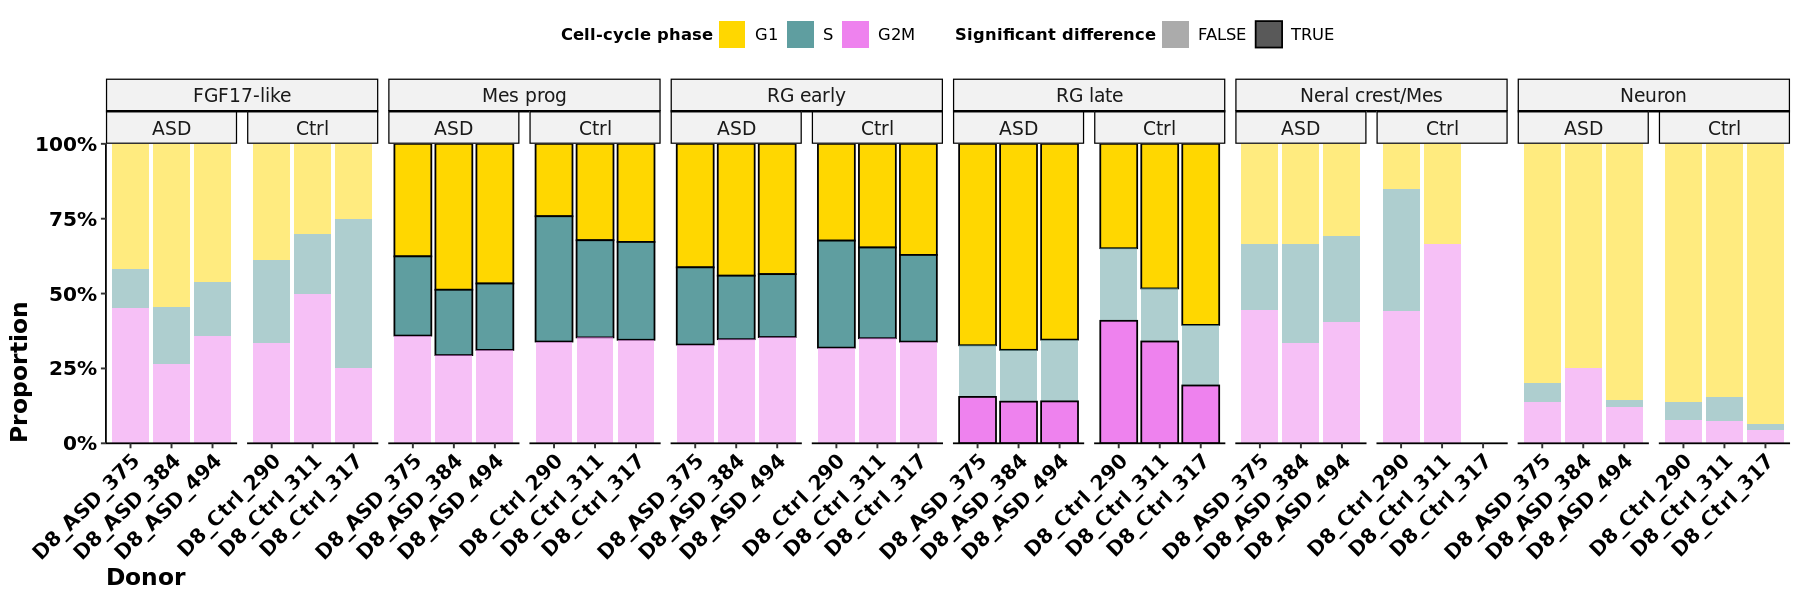

In [30]:
fig(15,5)
ct_phase.props.per.donor

#### Scatter

In [31]:
ct_phase.props.per.cluster <- ggplot(ct_phase.plot.props, aes(x=condition, y=value, fill=sample)) + 
    facet_grid2(rows=vars(clusters), cols=vars(cell.type), scales='free', space='fixed', independent='all', switch='y') + 
    geom_vline(xintercept = c('ASD', 'Ctrl'), color='lightgrey') +
    geom_jitter(shape=21, size=3, height = 0, width=0.1) + 
    scale_fill_manual('Donor', values = samples.colors) +
    scale_y_continuous(labels = scales::percent, expand = expansion(mult = c(0.1, 0.2))) + 
    theme_pubr(legend = 'top') + labs_pubr() +
    labs(x='Condition', y='Proportion') +
    theme(axis.title.x = element_text(hjust=0),
          axis.title.y = element_text(hjust=0)) + 

    geom_signif(
        data = annotation_df,
        aes(annotations = label, xmin = 'ASD', xmax = 'Ctrl', y_position = y),
        fill='black',
        manual = TRUE)

Warning message in geom_signif(data = annotation_df, aes(annotations = label, xmin = "ASD", :
“Ignoring unknown parameters: `fill`”
Warning message in geom_signif(data = annotation_df, aes(annotations = label, xmin = "ASD", :
“Ignoring unknown aesthetics: annotations, xmin, xmax, and y_position”


Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


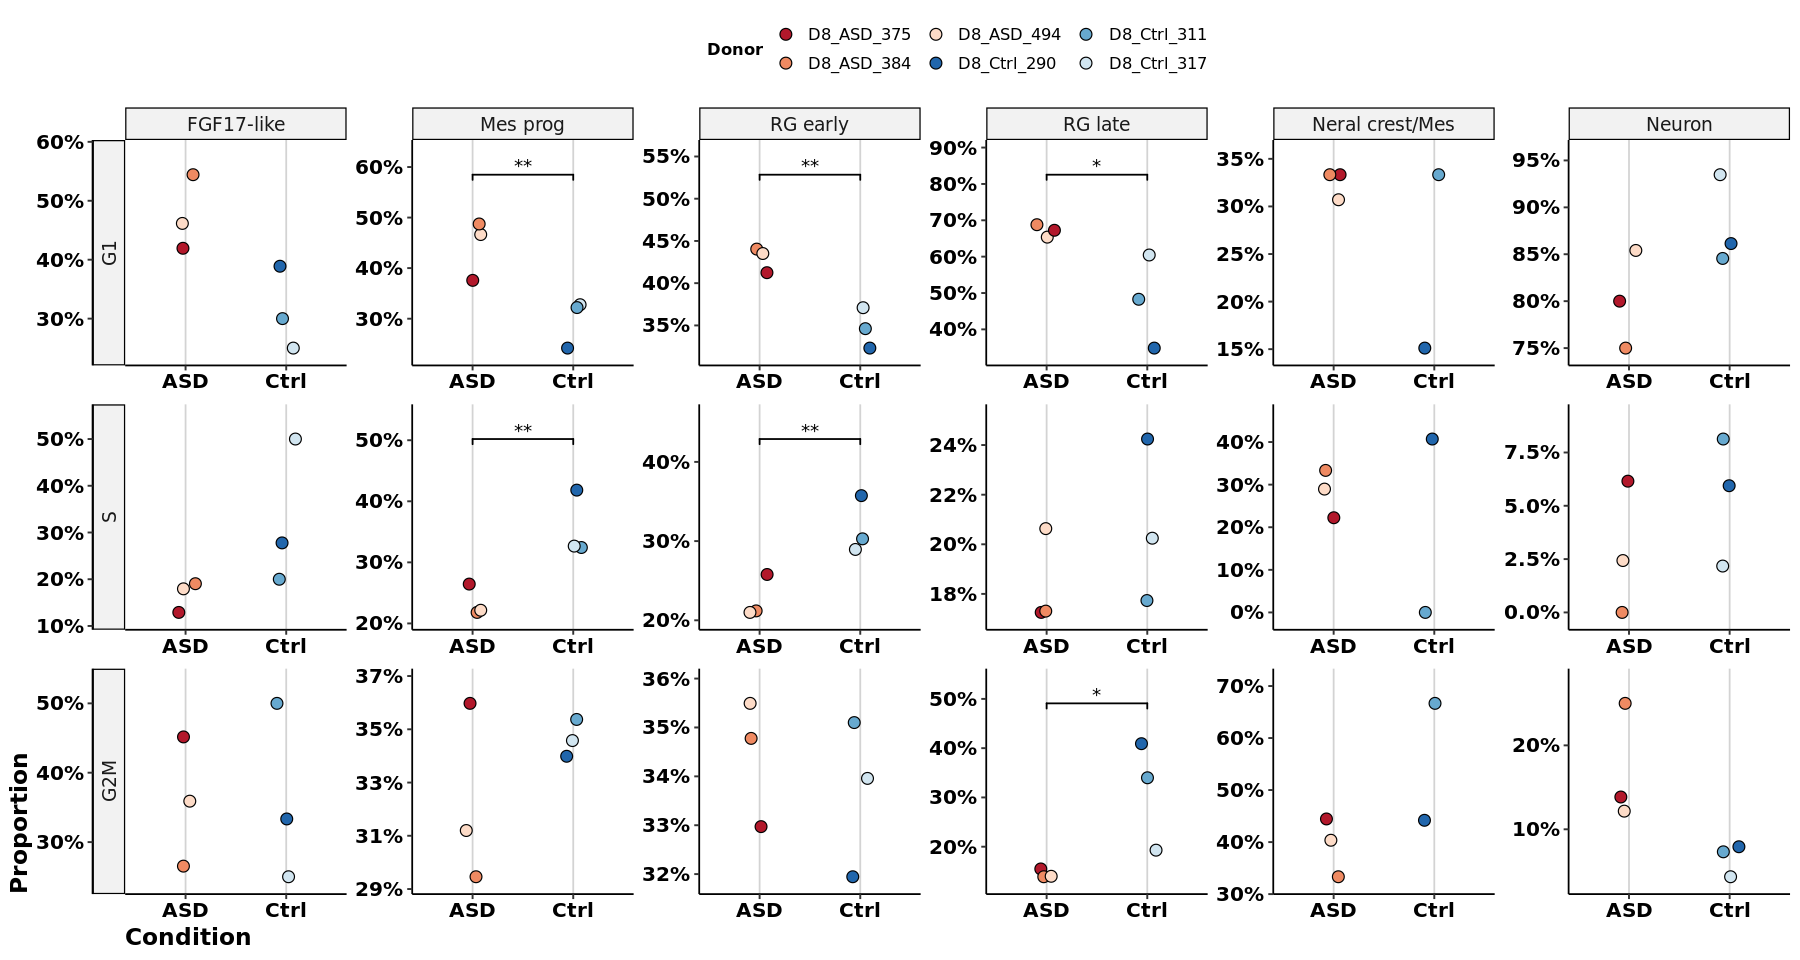

In [32]:
fig(15,8)
ct_phase.props.per.cluster

### Export

In [33]:
# Export
my_table <- tableGrob(ct_phase.res)

pdf(glue('{results_dir}Abundance.Test.PhasesPerCellType.{propeller.transform}.pdf'), width=15, height=8)
plot(ct_phase.props.per.donor)
plot(ct_phase.props.per.cluster)
plot(my_table)
dev.off()

Warning message:
“Removed 3 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


png 
  2

### Panel B. Phase composition

In [34]:
pdf(glue('{results_dir}phase_composition.pdf'), height=6, width=12)
ct_phase.props.per.cluster
ct_phase.props.per.donor
dev.off()

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values (`position_stack()`).”


png 
  2

Warning message:
“Removed 3 rows containing missing values (`position_stack()`).”


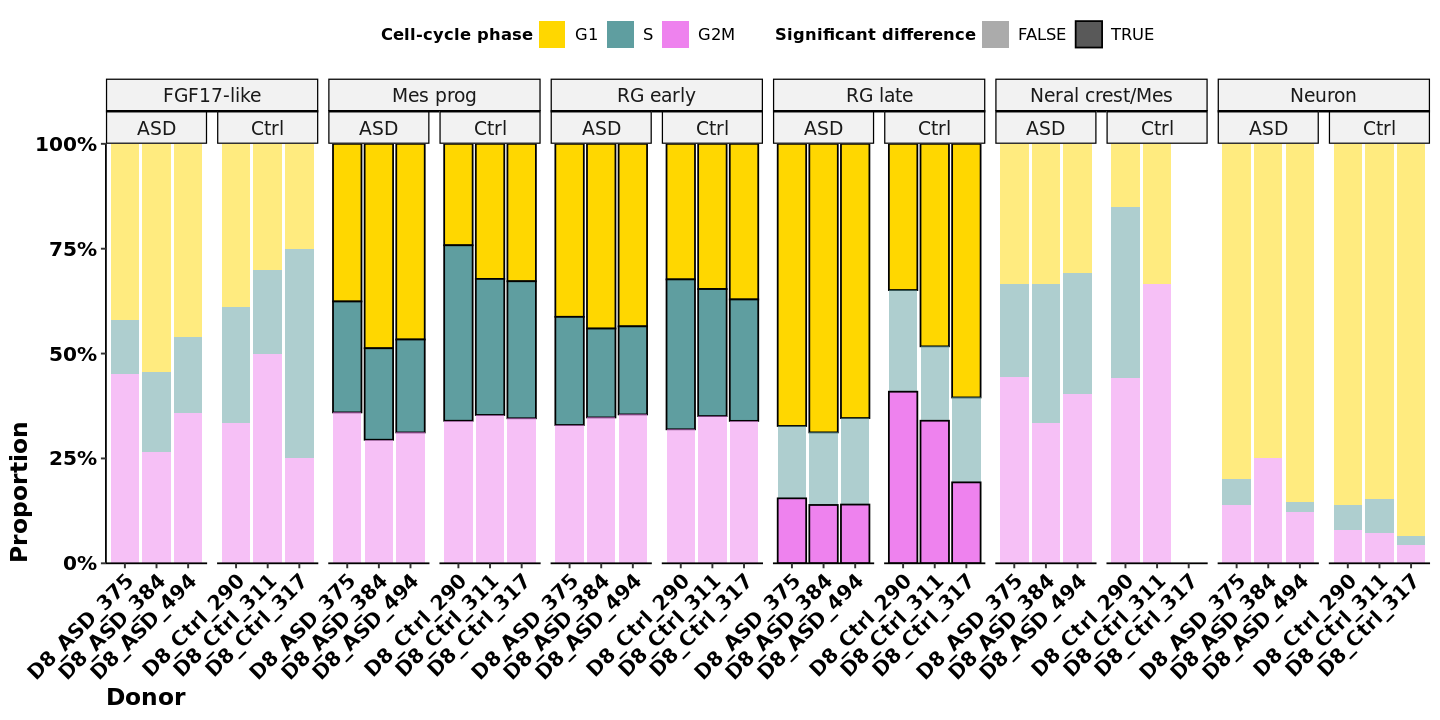

In [35]:
fig(12,6)
ct_phase.props.per.donor

### Explore data

In [36]:
head(seu@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,nCount_DS,nFeature_DS,cell_origin,time,condition,⋯,Phase,RNA_snn_res.1.2,seurat_clusters,anno_cell,anno_cluster,anno_cluster_fct,origin_sex,anno_origin,group,sample
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<chr>,<chr>,⋯,<fct>,<chr>,<fct>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<fct>
D8_Ctrl_290_AAACCCAGTTTGCAGT-1,D8,16371,4236,5.023006,27.589933,16371,4236,D8_Ctrl_290,D8,Ctrl,⋯,S,8,8,Mes prog,Mes prog,Mes prog,Male,Mes prog D8_Ctrl_290,Ctrl,D8_Ctrl_290
D8_Ctrl_290_AAACCCATCACCCTGT-1,D8,16494,4443,4.644276,25.022647,16494,4443,D8_Ctrl_290,D8,Ctrl,⋯,G2M,9,9,RG early,RG early,RG early,Male,RG early D8_Ctrl_290,Ctrl,D8_Ctrl_290
D8_Ctrl_290_AAACCCATCCATACAG-1,D8,6874,2862,13.328236,9.760449,6874,2862,D8_Ctrl_290,D8,Ctrl,⋯,G2M,4,4,RG early,RG early,RG early,Male,RG early D8_Ctrl_290,Ctrl,D8_Ctrl_290
D8_Ctrl_290_AAACGAACATAGTCGT-1,D8,3141,1325,4.084637,32.713891,3141,1325,D8_Ctrl_290,D8,Ctrl,⋯,G1,3,3,RG early,RG early,RG early,Male,RG early D8_Ctrl_290,Ctrl,D8_Ctrl_290
D8_Ctrl_290_AAACGAAGTGCACAAG-1,D8,2361,1220,16.626448,14.044402,2361,1220,D8_Ctrl_290,D8,Ctrl,⋯,S,1,1,RG early,RG early,RG early,Male,RG early D8_Ctrl_290,Ctrl,D8_Ctrl_290
D8_Ctrl_290_AAACGAATCAGCCTCT-1,D8,6368,2223,3.390295,34.103993,6368,2223,D8_Ctrl_290,D8,Ctrl,⋯,G1,1,1,RG early,RG early,RG early,Male,RG early D8_Ctrl_290,Ctrl,D8_Ctrl_290


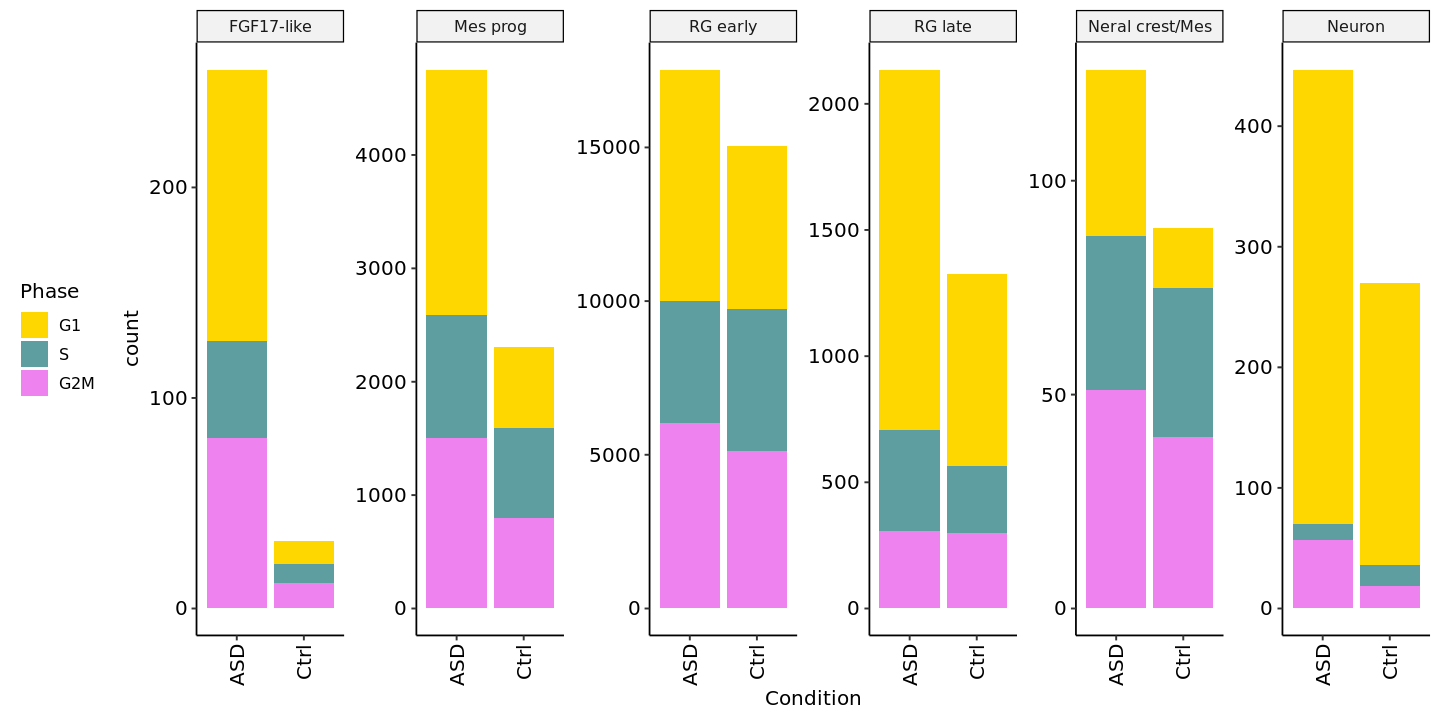

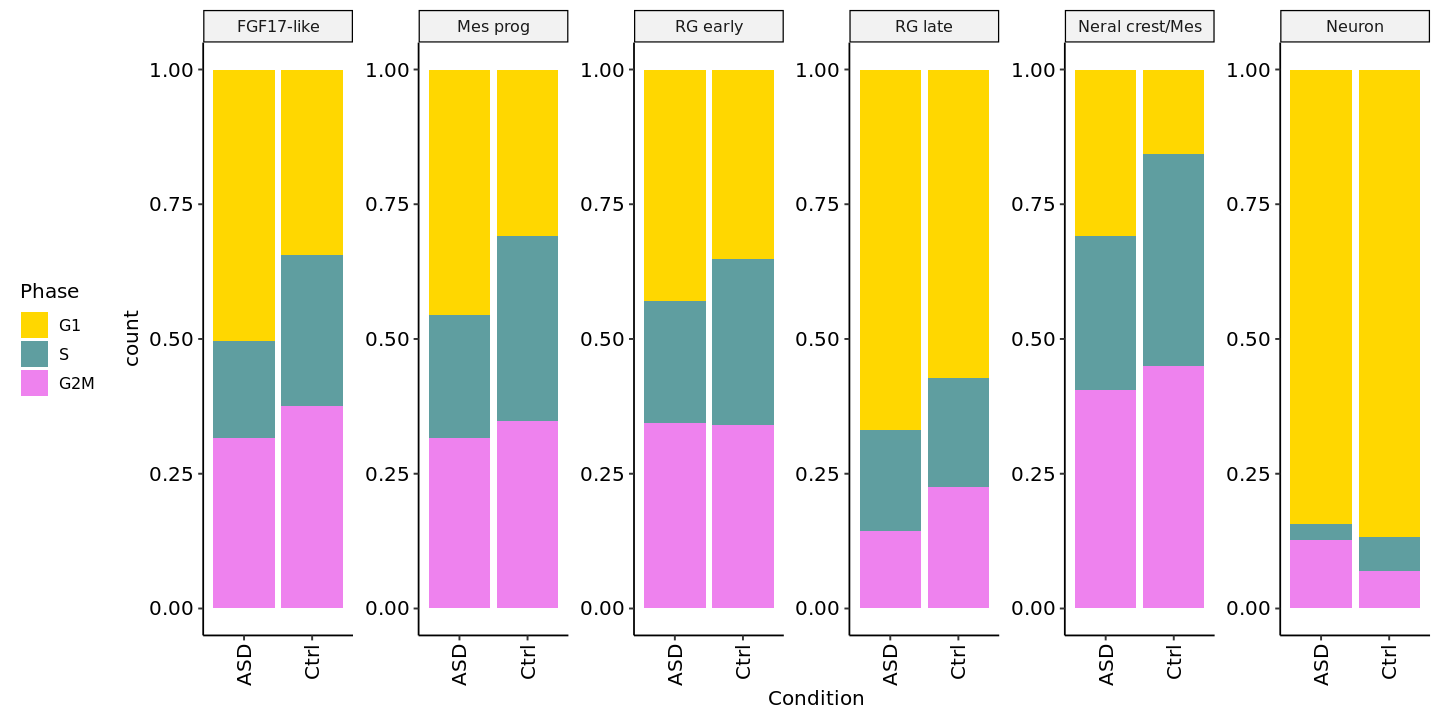

In [37]:
ggplot(seu@meta.data, aes(x=condition, 
                          fill=Phase)) + 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent = 'y') + 
    labs(fill='Phase', x='Condition') +
    scale_fill_manual(values=phases.colors) +
    geom_bar( position='stack') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))


ggplot(seu@meta.data, aes(x=condition, 
                          fill=Phase)) + 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent = 'y') + 
    labs(fill='Phase', x='Condition') +
    scale_fill_manual(values=phases.colors) +
    geom_bar( position='fill') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))


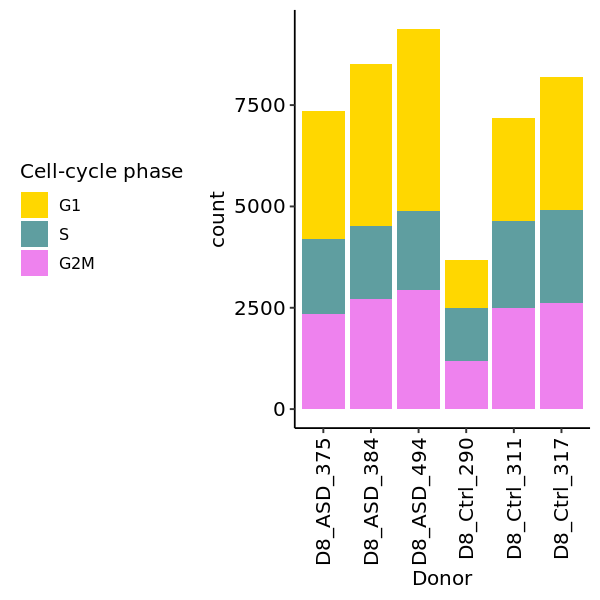

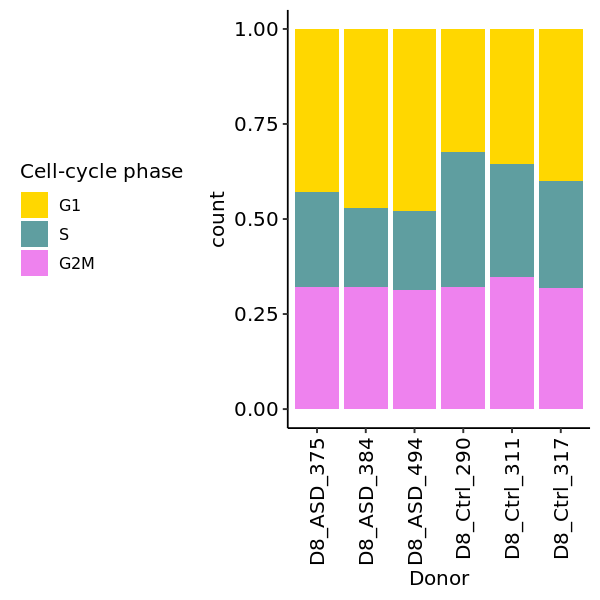

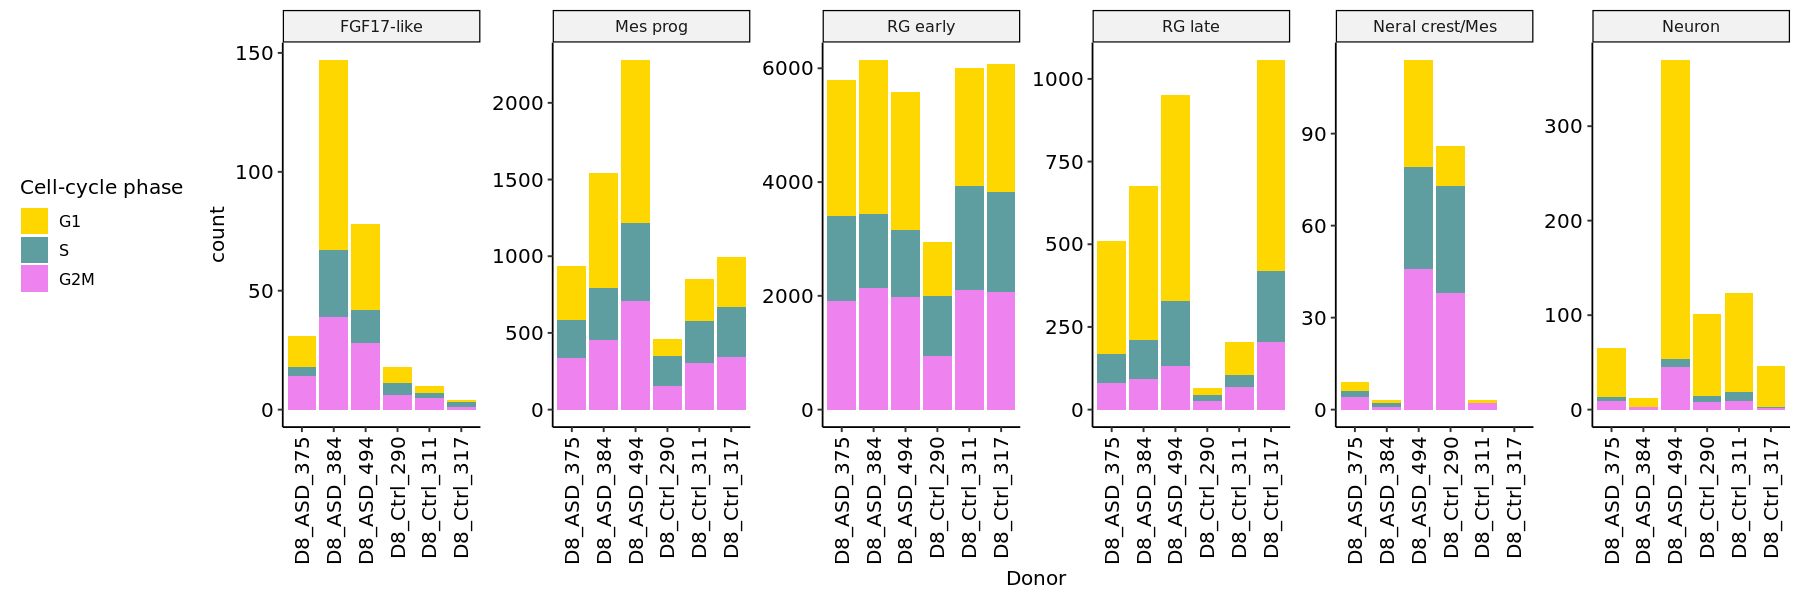

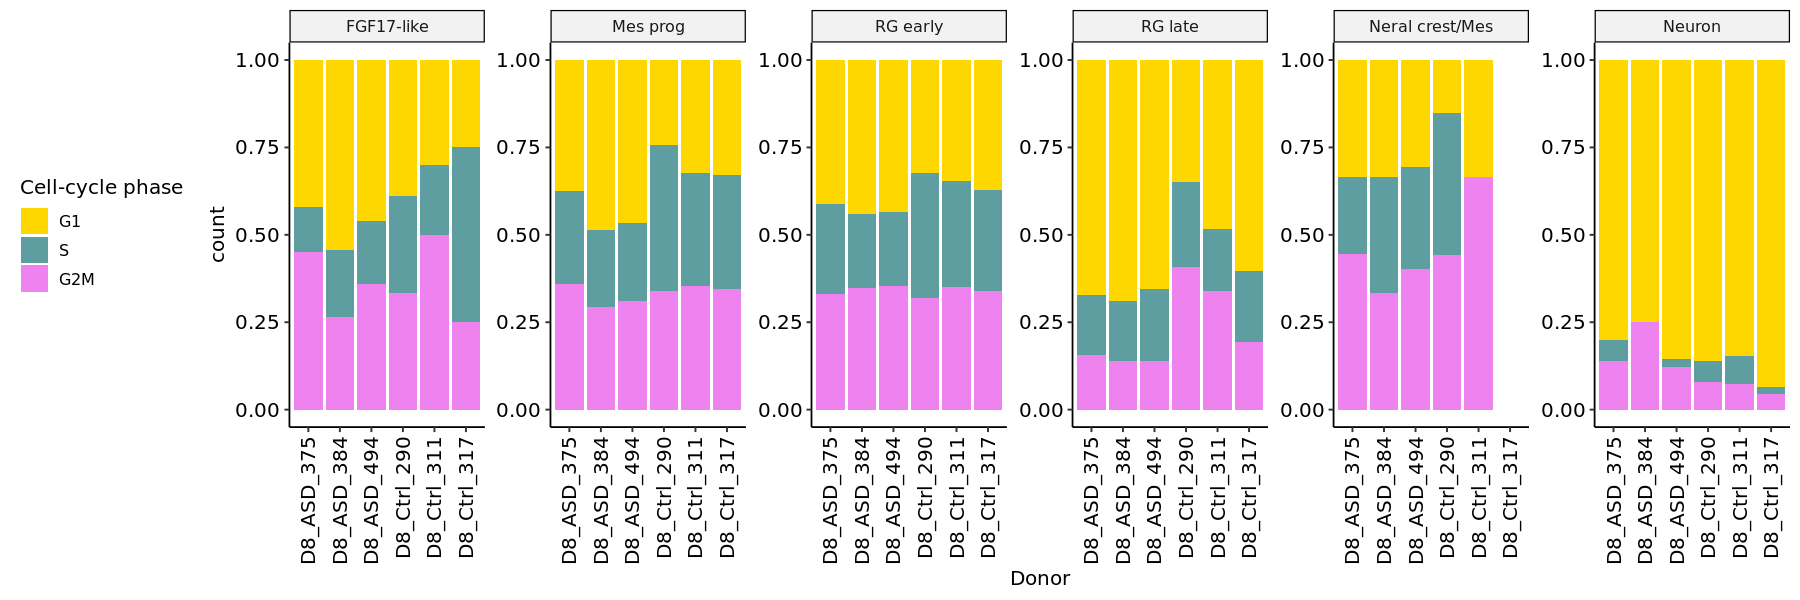

In [38]:
fig(5,5)
ggplot(subset(seu@meta.data, anno_cluster_fct!='High-mito'), aes(x=cell_origin, 
                          fill=factor(Phase, c('G1', 'S', 'G2M')))) + 
    # facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent = 'y') + 
    labs(x='Donor', fill='Cell-cycle phase') +
    scale_fill_manual(values=c('gold', 'cadetblue', 'violet')) +
    geom_bar( position='stack') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))

ggplot(subset(seu@meta.data, anno_cluster_fct!='High-mito'), aes(x=cell_origin, 
                          fill=factor(Phase, c('G1', 'S', 'G2M')))) + 
    # facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent = 'y') + 
    labs(x='Donor', fill='Cell-cycle phase') +
    scale_fill_manual(values=c('gold', 'cadetblue', 'violet')) +
    geom_bar( position='fill') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))

fig(15,5)
ggplot(subset(seu@meta.data, anno_cluster_fct!='High-mito'), aes(x=cell_origin, 
                          fill=factor(Phase, c('G1', 'S', 'G2M')))) + 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent = 'y') + 
    labs(x='Donor', fill='Cell-cycle phase') +
    scale_fill_manual(values=c('gold', 'cadetblue', 'violet')) +
    geom_bar( position='stack') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))

ggplot(subset(seu@meta.data, anno_cluster_fct!='High-mito'), aes(x=cell_origin, 
                          fill=factor(Phase, c('G1', 'S', 'G2M')))) + 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent = 'y') + 
    labs(x='Donor', fill='Cell-cycle phase') +
    scale_fill_manual(values=c('gold', 'cadetblue', 'violet')) +
    geom_bar( position='fill') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))


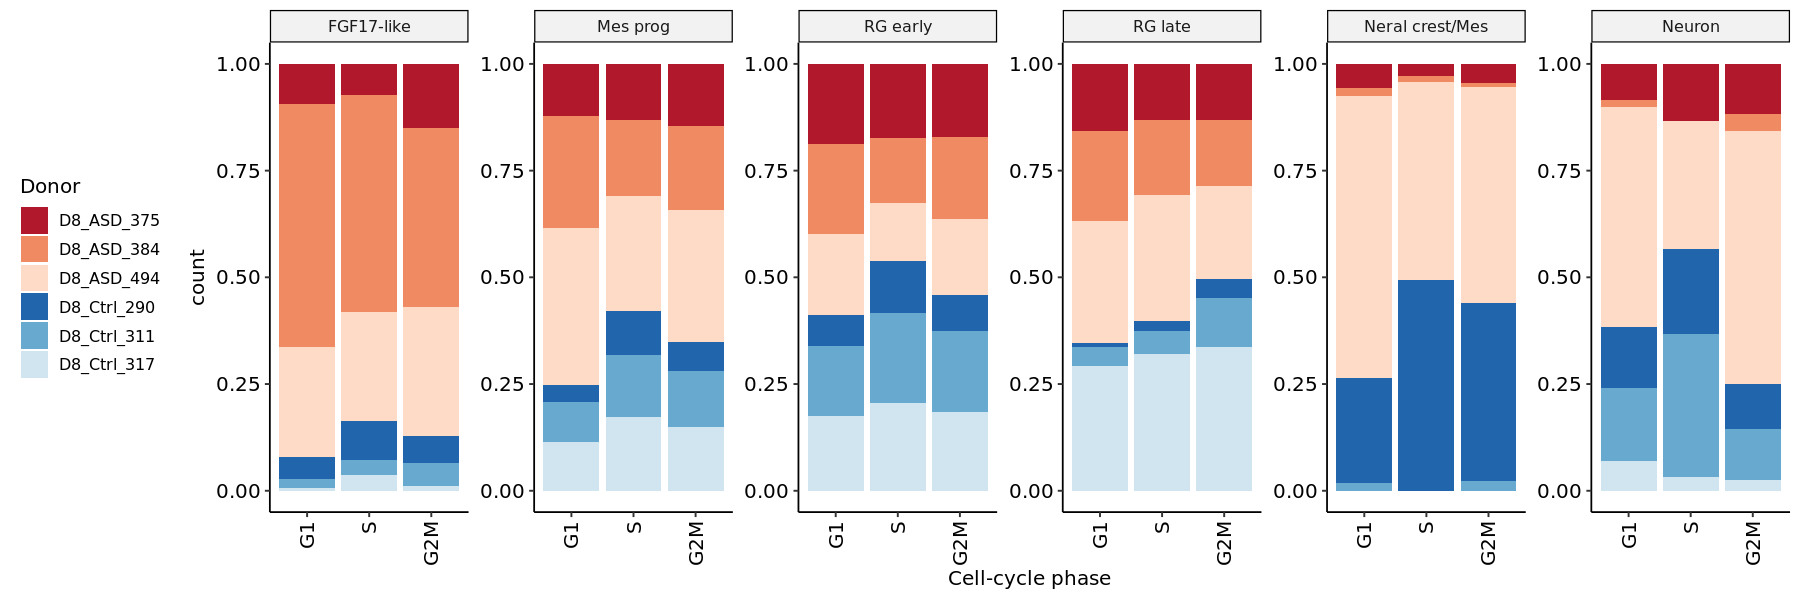

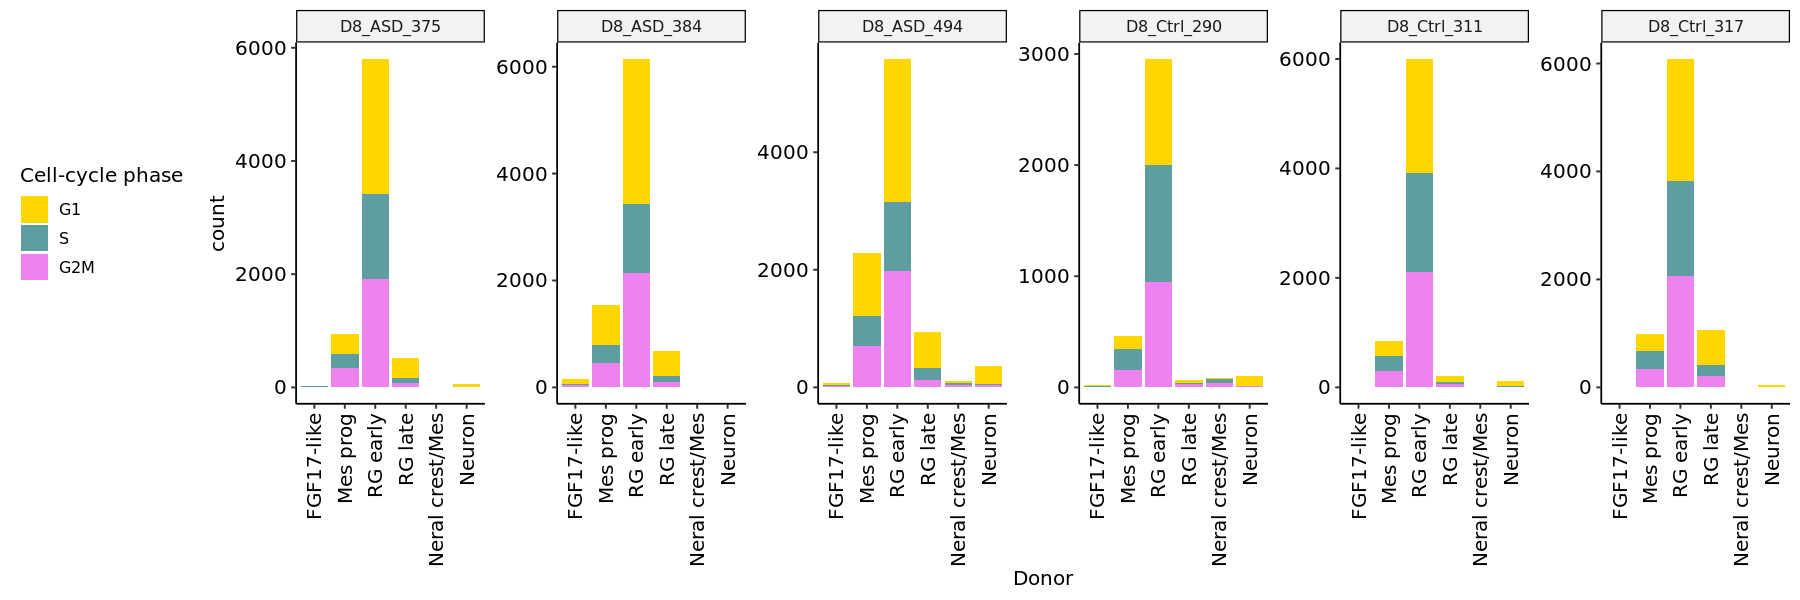

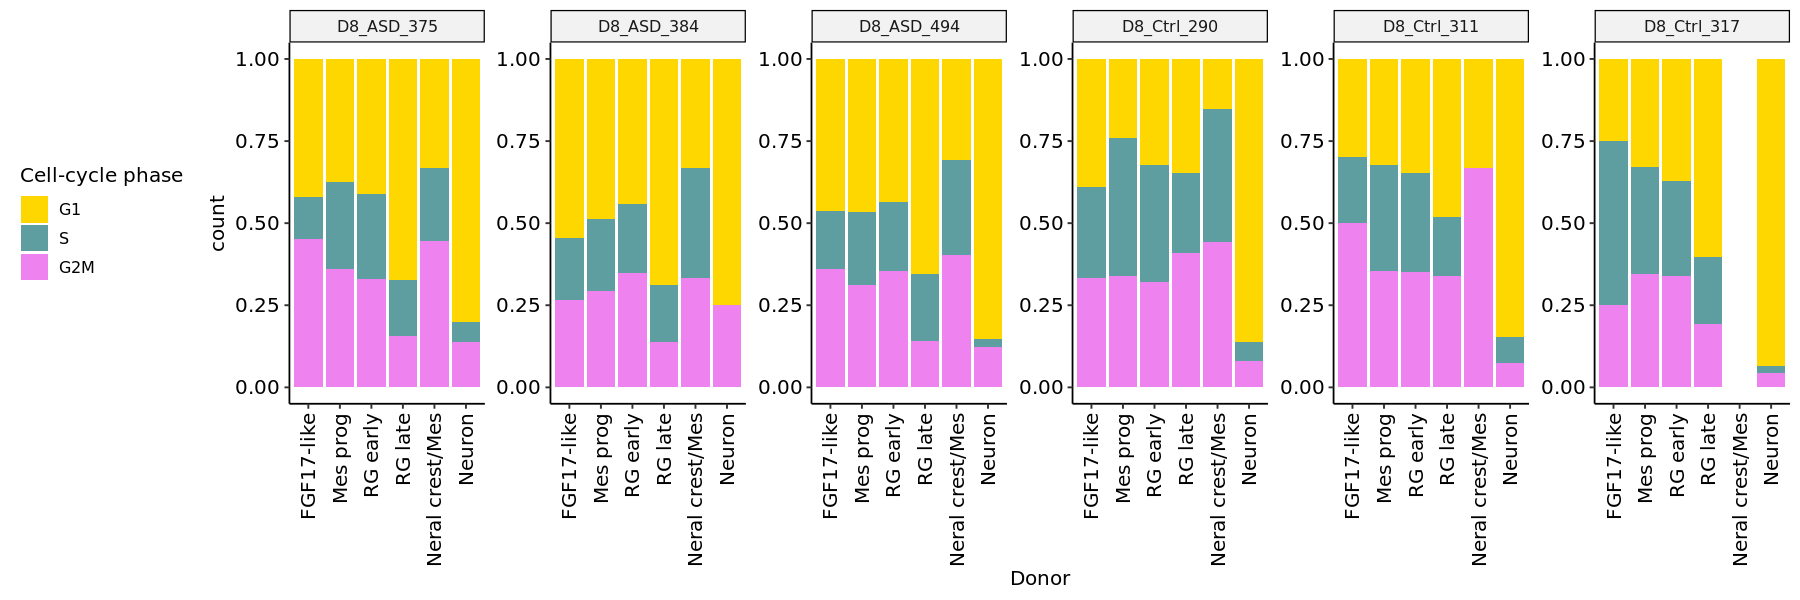

In [39]:
ggplot(seu@meta.data, aes(x=Phase, 
                          fill=cell_origin)) + 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent = 'y') + 
    labs(fill='Donor', x='Cell-cycle phase') +
    scale_fill_manual('Donor', values=samples.colors) +
    geom_bar( position='fill') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))

ggplot(seu@meta.data, aes(x=anno_cluster_fct, 
                          fill=Phase)) + 
    facet_grid2(cols=vars(cell_origin), scales='free_y', independent = 'y') + 
    labs(x='Donor', fill='Cell-cycle phase') +
    scale_fill_manual(values=phases.colors) +
    geom_bar( position='stack') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))

ggplot(seu@meta.data, aes(x=anno_cluster_fct, 
                          fill=Phase)) + 
    facet_grid2(cols=vars(cell_origin), scales='free_y', independent = 'y') + 
    labs(x='Donor', fill='Cell-cycle phase') +
    scale_fill_manual(values=phases.colors) +
    geom_bar( position='fill') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))


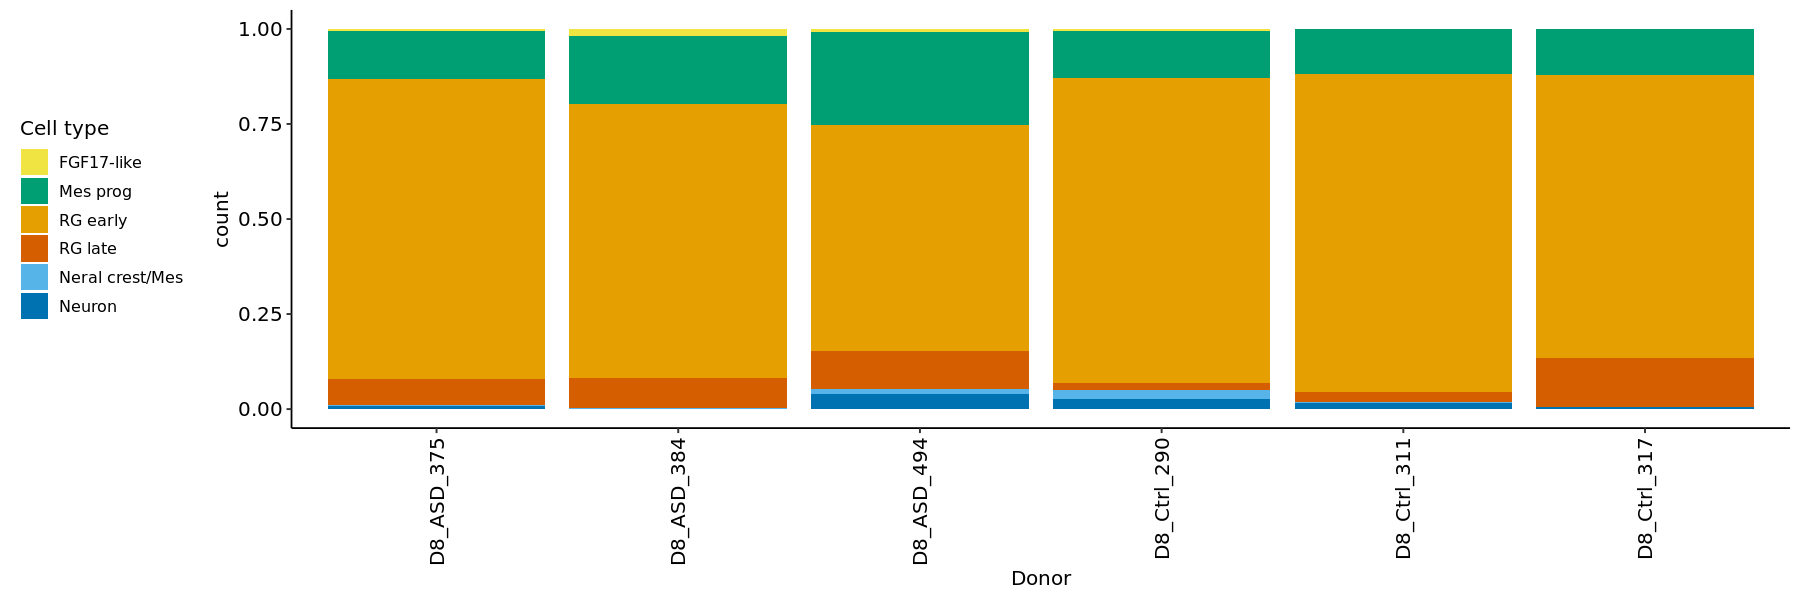

In [44]:

ggplot(seu@meta.data, aes(x=cell_origin, 
                          fill=anno_cluster_fct)) + 
    labs(x='Donor', fill='Cell-cycle phase') +
    scale_fill_manual('Cell type', values=cell.type.colors) +
    geom_bar( position='fill') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))


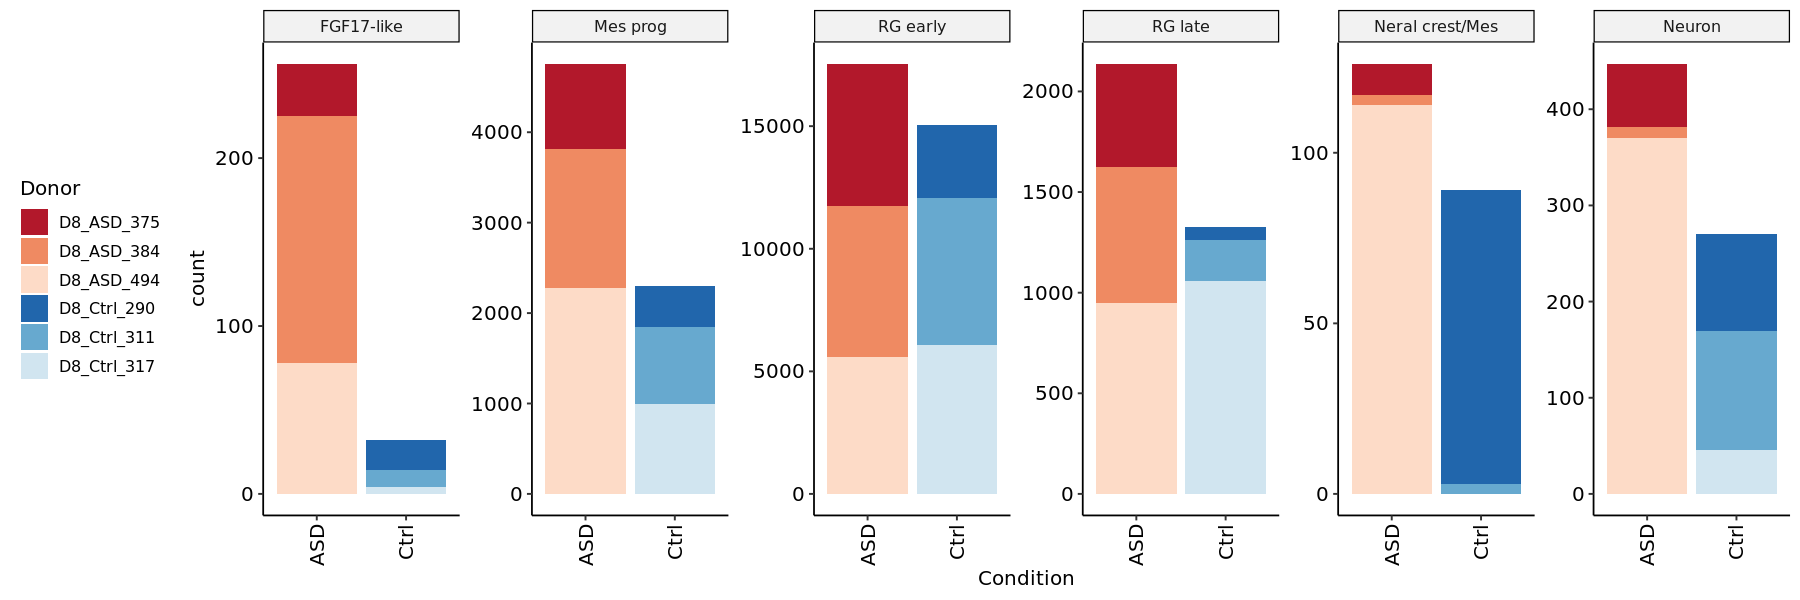

In [45]:
fig(15,5)

ggplot(seu@meta.data, aes(x=condition, 
                          fill=cell_origin)) + 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent = 'y') + 
    labs(fill='Donor', x='Condition') +
    scale_fill_manual(values=samples.colors) +
    geom_bar( position='stack') + ggpubr::theme_pubr(base_family='ArialMT', legend='left') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))


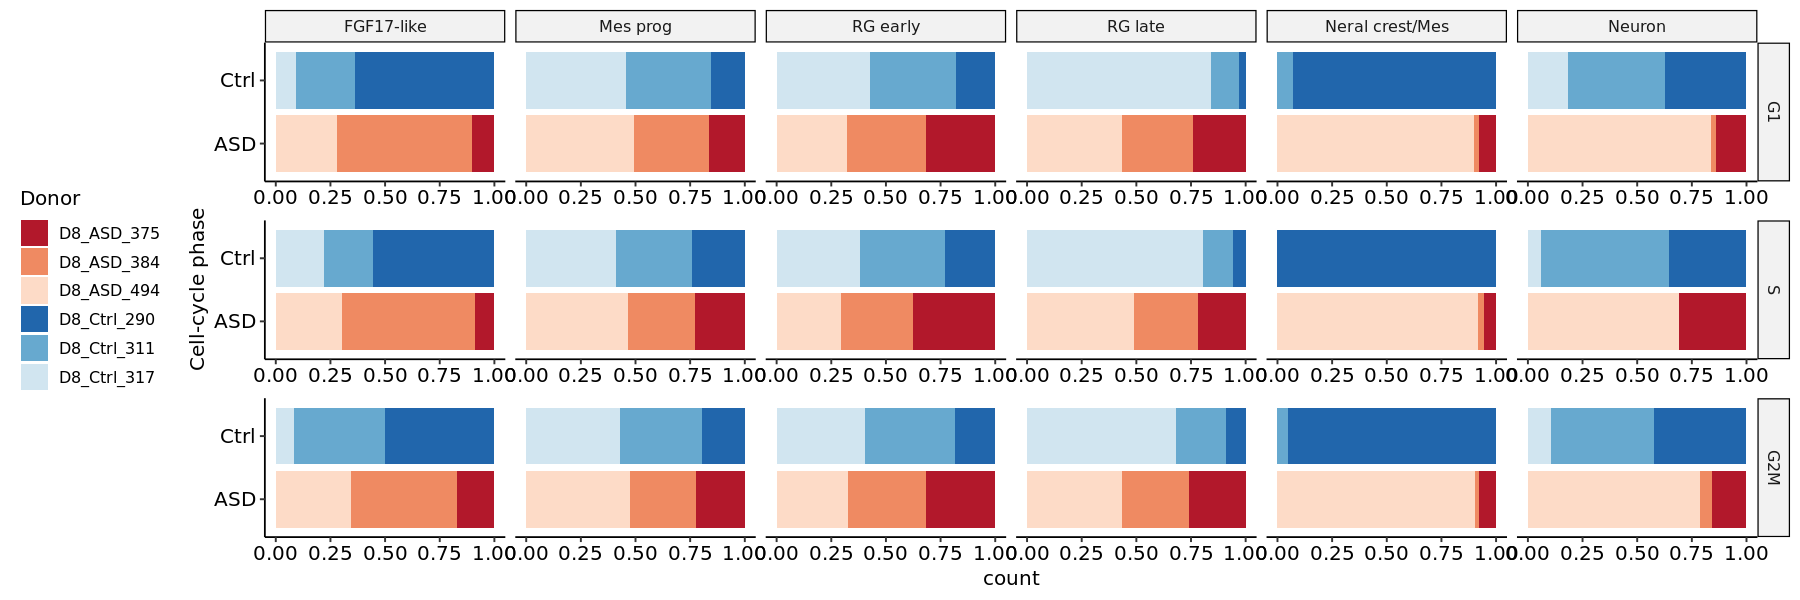

In [46]:
ggplot(seu@meta.data, aes(fill=cell_origin, 
                          y=condition)) + 
    facet_grid2(cols=vars(anno_cluster_fct), 
                rows=vars(Phase), 
                scales='free_x', independent = 'x') + 
    labs(fill='Donor', y='Cell-cycle phase') +
    scale_fill_manual(values=samples.colors) +
    geom_bar(position='fill') + ggpubr::theme_pubr(base_family='ArialMT', legend='left')


In [ ]:
ggplot(seu@meta.data, aes(y=cell_origin, 
                          fill=Phase)) + 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_x', independent = 'x') + 
    labs(y='Donor', fill='Cell-cycle phase') +
    scale_fill_manual(values=phases.colors) +
    geom_bar() + ggpubr::theme_pubr(base_family='ArialMT', legend='left')

ggplot(seu@meta.data, aes(fill=cell_origin, 
                          y=Phase)) + 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_x', independent = 'x') + 
    labs(fill='Donor', y='Cell-cycle phase') +
    scale_fill_manual(values=samples.colors) +
    geom_bar() + ggpubr::theme_pubr(base_family='ArialMT', legend='left')
